In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from datetime import timedelta
from joblib import delayed, Parallel
from copy import copy

from core import  do_simulation
from helpers import Params, T, get_T1_and_T2, R0, plot_total

from const import STATE, COLORS, NUM_STATES,  STATES


In [3]:
tran_coef_before = np.array([4.28, 5.28, 5.33, 4.38, 4.13, 5.27, 5.28, 5.32, 5.15, 5.22, 4.46, 4.20, 5.17, 5.11, 4.91, 4.92, 4.87, 4.04, 4.32, 4.22 , 3.60, 2.88])
tran_coef_after = np.array([0.66 ,0.67 ,0.68 ,0.66 ,0.69 ,0.69 ,0.66 ,0.69 ,0.68 ,0.67 ,0.60 ,0.62 ,0.61 ,0.62 ,0.62 ,0.61 ,0.60 ,0.62 ,0.67 ,0.60 ,0.58 ,0.59 ,0.58 ,0.57 ,0.59 ,0.60 ,0.57 ])
infection_factor = np.mean(tran_coef_before) / np.mean(tran_coef_after)
infection_factor = np.log(infection_factor)
infection_factor

1.999881671966743

In [4]:
params_jan27 = pkl.load(
    open('output/params_after_lockdown.pkl', 'rb')
)

In [5]:
params_jan27

total_population: 9000000
initial_num_E: 6000.0
initial_num_I: 6000.0
initial_num_M: 4000.0

alpha: 1.6e-08
beta:  1.6000000000000003e-09

mu_ei: 6.0

x0_pt: 10000
k_pt:  0.0001

mu_mo: 14.0

k_days: 28
        

In [6]:
lockdown_date = T('23/01/2020')
lockdown_date

datetime.datetime(2020, 1, 23, 0, 0)

In [7]:
target_E = params_jan27.initial_num_E
target_I = params_jan27.initial_num_I
actual_I = np.array([target_I])
actual_I

array([6000.])

In [8]:
def prepare_params(t):
    p = Params(
        alpha=[(0, infection_factor * params_jan27.alpha), (t, params_jan27.alpha)],
        beta=[(0, infection_factor * params_jan27.beta), (t, params_jan27.beta)],
        stages=[t],
        initial_num_E=1,
        initial_num_I=0,
        initial_num_M=0
    )
    return p
        

In [9]:
bed_info = [(0, 3000)]
def one_run(t):
    params = prepare_params(t)
    # t days **before** lockdown (Jan 23)
    # simulation finishes at Jan 27 (after lockdown for 5 days)
    # t=1, 2, 3, ... means patient zero  appeared in Jan 22, 21, 20
    total, _, _,r0_info = do_simulation(t+5, bed_info, params, verbose=0)
    
    pred_I = [total[-1, STATE.I]]
    mse = mean_absolute_error(actual_I, pred_I)
    return (t, pred_I, mse, r0_info)

In [10]:
# t is the number of days back
rows = Parallel(n_jobs=-1)(delayed(one_run)(t) for t in tqdm(range(30, 61)))

100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


In [11]:
df = pd.DataFrame(rows, columns=('t', 'pred_I', 'mse', 'r0_info'))

In [12]:
df.sort_values(by='mse').head(5)

,t,pred_I,mse,r0_info
24,54,[5809.922972854338],190.077027,"{0: (5.140396329080205, 2.380007259349445, 2.6..."
25,55,[7211.1694068367415],1211.169407,"{0: (5.1403771590792005, 2.390100335739419, 2...."
23,53,[4398.127417378557],1601.872583,"{0: (5.140406257529534, 2.3713234419093148, 2...."
22,52,[3385.7282195867556],2614.271780,"{0: (5.14040713062412, 2.363860765092019, 2.64..."
26,56,[9161.82144195592],3161.821442,"{0: (5.140348353998183, 2.4018133468496043, 2...."


In [13]:
best_t = int(df.sort_values(by='mse').iloc[0].t)
p0_time = T('22/01/2020') - timedelta(days=best_t)
print(p0_time)

2019-11-29 00:00:00


In [14]:
pkl.dump(p0_time, open('output/p0_time.pkl', 'wb'))

In [15]:
params = copy(params_jan27)
params.alpha = infection_factor * params.alpha
params.beta = infection_factor * params.beta
params.initial_num_E = 1
params.initial_num_I = 0
params.initial_num_M = 0

    
total, _, _, aux = do_simulation(best_t, bed_info, params, verbose=0)

100%|██████████| 54/54 [00:08<00:00,  6.46it/s]


In [16]:
pkl.dump(
    params,
    open('output/params_before_lockdown.pkl', 'wb')
)

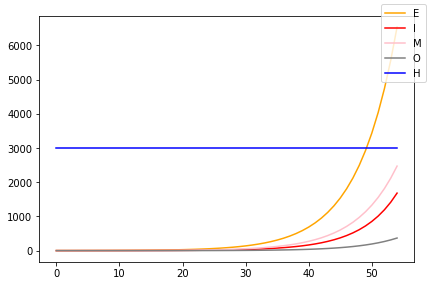

In [17]:
fig, ax = plot_total(total)
fig
fig.savefig('figs/before-lockdown.pdf')

In [18]:
df.sort_values(by='mse').iloc[0]['r0_info']

{0: (5.140396329080205, 2.380007259349445, 2.6503498884549033),
 1: (5.403214272643795, 2.5142550863101634, 1.8424381067784115)}